# Tarea 4

Implementar un código de simulación de Monte Carlo para el cálculo de las propiedades estructurales de sistemas con modelos de interacción de potencial continuo de Lennard-Jones. 
<center>$u(r)=4\epsilon[(\frac{\sigma}{r})^{12}-(\frac{\sigma}{r})^6]$</center>

Partiendo de una configuración inicial regular o aleatoria, muestre los resultados que obtiene, tomando como base las referencias citadas que se sugieren u otra.

In [89]:
#Importamos librerías y funciones
from matplotlib import pyplot
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd
from numba import jit, njit
from IPython.display import Image

In [90]:
#Definimos la función para generar el estado inicial de la muestra aleatoria
def muestraInicial(nr, N):
    i = 0
    muestraX = []
    muestraY = []
    muestraZ = []
    rad = 0.5
    L = ((N/nr)**(1./3.))/2 #Calculamos la longitud de la celda de tal modo que quede centrada
    while i < N:
        err = False
        x_n = np.random.rand()*(2*L - 2*rad) + (-L+rad)
        y_n = np.random.rand()*(2*L - 2*rad) + (-L+rad)
        z_n = np.random.rand()*(2*L - 2*rad) + (-L+rad)
        if i == 0: #La primer coordenada simplemente la agregamos a la lista
            muestraX.append(x_n)
            muestraY.append(y_n)
            muestraZ.append(z_n)
            i = i + 1
        elif i > 0: #A partir de la segunda coordenada generada comenzamos a evaluar las distancias entre los puntos
            for j in range(len(muestraX)):
                dist = np.sqrt((x_n - muestraX[j])**2 + (y_n - muestraY[j])**2 + (z_n - muestraZ[j])**2)
                if dist<2*rad: #Si la distancia es menor a dos veces el radio paramos la iteración e indicamos que hay un error con el valor generado 
                    err = True
                    break
                else:
                    continue
            if err == False: #Si no hay un error registrado entonces agregamos la coordenada generada a la lista
                muestraX.append(x_n)
                muestraY.append(y_n)
                muestraZ.append(z_n)
                i = i + 1
    return muestraX, muestraY, muestraZ

In [91]:
#Definimos la función que calcula el potencial total del sistema de partículas en su estado inicial
#Utilizaremos como argumentos el número de partículas, la longitud de la celda, el radio de corte, y los arreglos de posiciones
#de las partículas
@njit
def V_0(N, L, radC, x, y, z):
    V = 0
    i = 0
    eps = 1
#Iniciamos un bule para seleccionar la partícula
    while i < N:
        xi = x[i]
        yi = y[i]
        zi = z[i]
#Empezamos el bucle para calcular la distancia entre la partícula seleccionada y todas las demás
#se evalua si la distancia es mayor al radio de corte y se determina la aportación al potencial
        for j in range(i+1, N):
            xij = (xi - x[j])
            yij = (yi - y[j])
            zij = (zi - z[j])
            xij = xij - L*round(xij/L) #Aplicando la condición de imagen mínima
            yij = yij - L*round(yij/L) #Aplicando la condición de imagen mínima
            zij = zij - L*round(zij/L) #Aplicando la condición de imagen mínima
            rij = np.sqrt(xij**2 + yij**2 + zij**2)
            if rij < radC:
                if rij <= 1.:
                    Vij = np.inf
                elif rij > 1.:                    
                    Vij = 4*eps*((radC/rij)**12-(radC/rij)**6)
                V = V + Vij
        i = i +1
    return V

In [92]:
#Definimos la función que calcula la energía potencial de la j-ésima partícula en el i-ésimo estado
#Utilizamos de argumentos el número de partículas, la longitud de la celda, los arreglos de posiciones
#en "x" y "y", las posiciones de la partícula de la cual se quiere saber el potencial,  
@njit
def V_j(N, L, radC, x, y, z, xj, yj, zj, j):
    V = 0
    i = 0
    eps = 1
    while i < N:
        if j != i:
            xij = xj - x[i]
            yij = yj - y[i]
            zij = zj - z[i]
            xij = xij - L*round(xij/L) #Aplicando la condición de imagen mínima
            yij = yij - L*round(yij/L) #Aplicando la condición de imagen mínima
            zij = zij - L*round(zij/L) #Aplicando la condición de imagen mínima
            rij = np.sqrt(xij**2 + yij**2 + zij**2)
            if rij < radC:
                if rij <= 1.:
                    Vij = np.inf
                elif rij > 1.:
                    Vij = 4*eps*((radC/rij)**12-(radC/rij)**6)
                V = V + Vij
        i = i + 1
    return V
#Esta función se utilizará dentro de la función de movimiento de las partículas

In [93]:
#Definimos la función de movimiento de las partículas
#Utilizamos como argumento los arreglos de las posiciones en "x", "y", "z", el número de partículas, la longitud de la celda,
#el número de estados, el radio de corte, la distancia máxima que pueden moverse las partículas, la frecuencia de corrección
#de paso, la frecuencia con la que se imprimen datos en pantalla, el criterio de correción, el potencial del estado inicial,
#la partícula trazadora y la corrección de largo alcance.
@njit
def movPart(x, y, z, N, L, nStep, radC, drMax, iRatio, iPrint, cc, V, iTraza, Vlrc, Nener):
    numIter = 0 #Contador de iteraciones exitosas antes de cambiar el valor de la distancia máxima
    xTraza = np.zeros(nStep)
    yTraza = np.zeros(nStep)
    zTraza = np.zeros(nStep)
    vTraza = np.zeros(nStep)
    
#Creamos matrices para las posiciones de x, y, y z en cada configuración
    Mx = np.zeros((N, nStep))
    My = np.zeros((N, nStep))
    Mz = np.zeros((N, nStep))
    ki = 0 #Contador para almacenar posiciones en las matrices
    
#Abrimos un bucle para calcular el potencial de la j-ésima partícula en el i-ésimo estado con la función de potencial definida
#anteriormente, calcular la nueva posición, luego el nuevo potencial, y luego la diferencia de potencial entre estados
    for i in range(nStep):
        for j in range(N):
            x1 = x[j]
            y1 = y[j]
            z1 = z[j]
            V1 = V_j(N, L, radC, x, y, z, x1, y1, z1, j)
            x2 = x1 + ((2.*rd.uniform(0,1) - 1.)*drMax)
            y2 = y1 + ((2.*rd.uniform(0,1) - 1.)*drMax)
            z2 = z1 + ((2.*rd.uniform(0,1) - 1.)*drMax)
            
            x2 = x2 - L*round(x2/L) #Aplicamos condición de imagen mínima
            y2 = y2 - L*round(y2/L) #Aplicamos condición de imagen mínima
            z2 = z2 - L*round(z2/L) #Aplicamos condición de imagen mínima
            V2 = V_j(N, L, radC, x, y, z, x2, y2, z2, j)
            
            dV = V2 - V1
#Abrimos un condicional que evalúe si el cambio de potencial es aceptable o no para saber si el cambio de posición lo es también
#y si se cumple sustituímos los valores existente en los arreglos de coordenadas por los nuevos 
            if dV < 75.:
                if dV <= 0.:
                    V = V + dV
                    x[j] = x2
                    y[j] = y2
                    z[j] = z2
                    numIter = numIter + 1
                elif np.exp(-dV) > rd.uniform(0,1):
                    V = V + dV
                    x[j] = x2
                    y[j] = y2
                    z[j] = z2
                    numIter = numIter + 1
#Guardamos los valores de las posiciones a partir de la configuración de termalización en las matrices                    
            if i > Nener:
                Mx[j][ki] = x[j]
                My[j][ki] = y[j]
                Mz[j][ki] = z[j]
#Un condicional que agrega las coordenadas de la j-ésima partícula a un arreglo de coordenadas de la partícula trazadora
            if j==iTraza:
                xTraza[i] = x[j]
                yTraza[i] = y[j]
                zTraza[i] = z[j]
#Se calcula el potencial del i-ésimo estado
        V_i = (V + Vlrc)/float(N)
#Se abre un condicional para revisar si es momento de cambiar el valor de la distancia máxima y si debe aumentar o disminuir
#según el criterio de correción
        if i % iRatio == 0:
            ratio = numIter/float((N*iRatio))
            if ratio > cc:
                drMax = drMax*1.05
            else:
                drMax = drMax*0.95
            numIter = 0.
#Si el número de iteraciones es algún múltiplo de la frecuencia de impresión entonces se imprimen los valores de la iteración,
#el ratio, la distancia máxima, y el potencial del i-ésimo estado.
        if i % iPrint == 0:
            print (i, ratio, drMax, V_i,"\n")
#Creamos un arreglo para los valores del potencial del i-ésimo estado
        vTraza[i] = V_i

        if i > Nener:
            ki = ki +1

#La función regresa los arreglos de posiciones en "x" y "y", y las posiciones de la partícula trazadora
    return x, y, z, xTraza, yTraza, zTraza, vTraza, Mx, My, Mz, ki

In [108]:
#Definimos la función de distribución radial
@njit
def gdr(Mx, My, Mz, radC, L, nStep, nr, N, ki):
    #Definimos valores a utilizar
    nhist = np.zeros(int(nStep)) #Lista de circunferencias alrededor de la partícula
    dr = 0.01 #Ancho de paso para circunferencias
    maxbin = int(L/2/dr) #Máximo número de circunferencias
    #Abrimos un loop para calcular el radio de las circunferencias alrededor de la partícula
    for i in range(N):
        for j in range(N):
            if i != j :
                for k in range(ki):
                    x0 = Mx[i,k]
                    x1 = Mx[j,k]
                    x2 = x0-x1
                    y0 = My[i,k]
                    y1 = My[j,k]
                    y2 = y0-y1
                    z0 = Mz[i,k]
                    z1 = Mz[j,k]
                    z2 = z0-z1
                    #Condición de imagen mínima
                    x2 = x2-L*round(x2/L)
                    y2 = y2-L*round(y2/L)
                    z2 = z2-L*round(z2/L)
                    #Calculamos el radio de la circunferencia
                    R = np.sqrt(x2**2 + y2**2 + z2**2)
                    #Guardamos la circunferencia en la lista si se cumple la condición
                    nBin = int(R/dr)+1
                    if nBin <= maxbin :
                        nhist[nBin] = nhist[nBin] + 1

    c1 = 4.0*(np.pi)*nr/3.0
    
    gdrTA = np.zeros(maxbin) #Arreglo de número de partículas en volumen dado por el radio de la circunferencia
    rt = np.zeros(maxbin) #Arreglo de distancias en dr's
    for i in range(maxbin):
        rl = float(i-1)*dr
        ru = rl + dr
        rt[i] = rl + dr/2.0
        c2 = c1*(ru**3 - rl**3)
        gdrTA[i] = float(nhist[i])/float(ki)/float(N)/c2
    return rt, gdrTA

In [135]:
#Definimos la función de distribución radial
@njit
def gdr1(Mx, My, Mz, radC, L, nStep, nr, N, ki):
    #Definimos valores a utilizar
    nhist = np.zeros(int(nStep)) #Lista de circunferencias alrededor de la partícula
    dr = 0.01 #Ancho de paso para circunferencias
    maxbin = int(L/2/dr) #Máximo número de circunferencias
    #Abrimos un loop para calcular el radio de las circunferencias alrededor de la partícula
    for i in range(N):
        for j in range(N):
            if i != j :
                for k in range(ki):
                    x0 = Mx[i,k]
                    x1 = Mx[j,k]
                    x2 = x0-x1
                    y0 = My[i,k]
                    y1 = My[j,k]
                    y2 = y0-y1
                    z0 = Mz[i,k]
                    z1 = Mz[j,k]
                    z2 = z0-z1
                    #Condición de imagen mínima
                    x2 = x2-L*round(x2/L)
                    y2 = y2-L*round(y2/L)
                    z2 = z2-L*round(z2/L)
                    #Calculamos el radio de la circunferencia
                    R = np.sqrt(x2**2 + y2**2 + z2**2)
                    #Guardamos la circunferencia en la lista si se cumple la condición
                    nBin = int(R/dr)+1
                    if nBin <= maxbin :
                        nhist[nBin] = nhist[nBin] + 1

    c1 = 4.0*(np.pi)*nr/3.0
    
    gdrTA = np.zeros(maxbin) #Arreglo de número de partículas en volumen dado por el radio de la circunferencia
    rt = np.zeros(maxbin) #Arreglo de distancias en dr's
    for i in range(maxbin):
        rl = float(i-1)*dr
        ru = rl + dr
        rt[i] = rl + dr/2.0
        c2 = c1*(ru**3 - rl**3)
        gdrTA[i] = float(nhist[i])/float(ki)/float(N)/c2
    return rt, gdrTA

In [165]:
#Definimos la función para calcular la presión del sistema
@njit
def pres(rt, gdr, nr):
    for i in range(len(rt)):
        if rt[i] > (1.0-0.01) and rt[i] > (1.0 + 0.01):
            xog = gdr[i]
            isig = i
    
    print("ICONTACTO = ", isig, ", GDR DE CONTACTO = ", xog)
    
    #Calculo de presión de un sistema hs
    phs = nr + 2.0 * np.pi * nr * xog / 3.0
    
    return phs

**a) Configuración inicial y final**

In [117]:
#Definimos los valores que utilizaremos
nStep = 10000 #Número de estados del sistema que se quieren simular
nFrec = 100 #Frecuencia con la que se guardan los datos
Nener = 6000 #Iteración donde se alcanza equilibrio termodinámico
iPrint = 1000 #Frecuencia con la que se imprimen en pantalla los resultados
iRatio = 1000 #Frecuencia de correción de paso
cc = 0.5 #Criterio de corrección
drMax = 0.1 #Longitud de paso 

In [140]:
#Pedimos al usuario que ingrese diferentes valores para el número de partículas y la concentración reducida
print('Número de partículas:', end = '')
N = int(input())
print('Concentración reducida:', end = '')
nr = float(input())
#Calculamos la longitud de celda y la imprimimos
L = ((N/nr)**(1./3.))
print('Longitud de celda:', L, '\n', end = '')
#Calculamos el radio de corte y lo imprimimos
radC = L/2
print('Radio de corte:', radC,  '\n', end = '')

Número de partículas:1200
Concentración reducida:0.6
Longitud de celda: 12.59921049894873 
Radio de corte: 6.299605249474365 


In [141]:
#Generamos la muestra aleatoria en su estado inicial, hacemos arreglos con las listas y hacemos un dataframe
muestraX, muestraY, muestraZ = muestraInicial(nr, N)
muestraX = np.array(muestraX)
muestraY = np.array(muestraY)
muestraZ = np.array(muestraZ)
muestra0 = {'x_0': muestraX, 'y_0': muestraY, 'z_0': muestraZ} 
df0 = pd.DataFrame(muestra0)

In [142]:
#Calculamos el potencial inicial del sistema
V = V_0(N, L, radC, muestraX, muestraY, muestraZ)
Vlrc = 0 #No hay correción de largo alcance (potencial de corto alcance)
V0 = V + Vlrc
#Imprimimos el potencial del estado inicial de la muestra
print('Potencial inicial:', V0, end = '')

Potencial inicial: 16967465503377.957

In [143]:
#Tomamos una partícula trazadora
iTraza = int(rd.uniform(0,N))
if iTraza == N:
    iTraza = N-1
#Imprimimos el número de la partícula trazadora
print('Particula trazadora:', iTraza, end = '')

Particula trazadora: 630

In [144]:
#Utilizamos la función de movimiento de partículas para obtener las posiciones finales y la traza
muestraFx, muestraFy, muestraFz, xTraza, yTraza, zTraza, vTraza, Mx, My, Mz, ki = movPart(muestraX, muestraY, muestraZ, N, L, nStep, radC, drMax, iRatio, iPrint, cc, V0, iTraza, Vlrc, Nener)
muestraF = {'x_f': muestraFx, 'y_f': muestraFy, 'z_f': muestraFz} #Creamos lista de listas para las posiciones finales
traza = {'x': xTraza, 'y': yTraza, 'z': zTraza} #Creamos lista de listas para las posiciones de la traza
df1 = pd.DataFrame(muestraF)
dfT = pd.DataFrame(traza)

0 0.000315 0.095 12916681187.897543 

1000 0.0206225 0.09025 3944176258.5692735 

2000 0.003998333333333333 0.0857375 3855345549.0659885 

3000 0.002384166666666667 0.08145062499999998 3823540669.005606 

4000 0.0016375 0.07737809374999999 3808121164.8913045 

5000 0.0014866666666666667 0.07350918906249998 3796720155.7526393 

6000 0.0014416666666666666 0.06983372960937498 3786430334.8175797 

7000 0.001345 0.06634204312890622 3777736916.828635 

8000 0.001465 0.0630249409724609 3769814021.0851903 

9000 0.0014091666666666666 0.05987369392383786 3762639224.757378 



Text(0.5, 0, 'z')

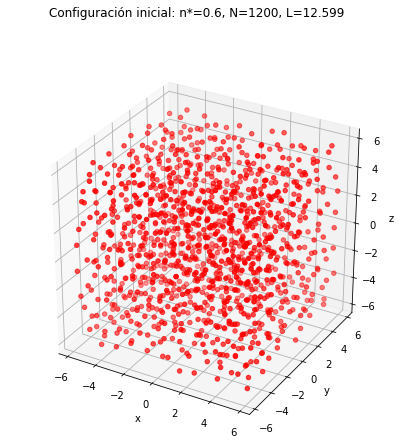

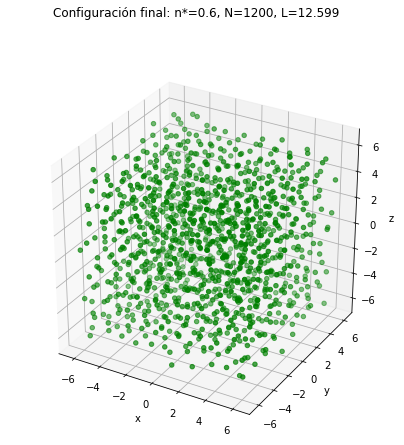

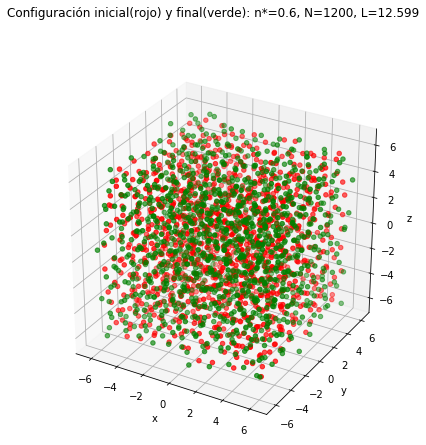

In [157]:
#Graficamos la configuración inicial
fig = plt.figure()
fig.set_size_inches(7,7)
fig.suptitle('Configuración inicial: n*=0.6, N=1200, L=12.599')
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(df0['x_0'], df0['y_0'], df0['z_0'], c = 'r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

#Graficamos la configuración final
fig = plt.figure()
fig.set_size_inches(7,7)
fig.suptitle('Configuración final: n*=0.6, N=1200, L=12.599')
ax2 = fig.add_subplot(projection='3d')
ax2.scatter(df1['x_f'], df1['y_f'], df1['z_f'], c = 'g')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

#Graficamos la configuración inicial y final
fig = plt.figure()
fig.set_size_inches(7,7)
fig.suptitle('Configuración inicial(rojo) y final(verde): n*=0.6, N=1200, L=12.599')
ax3 = fig.add_subplot(projection='3d')
ax3.scatter(df0['x_0'], df0['y_0'], df0['z_0'], c = 'r')
ax3.scatter(df1['x_f'], df1['y_f'], df1['z_f'], c = 'g')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')

**b) Curva de termalización (energía potencial por partícula)**

Text(0, 0.5, 'Potencial')

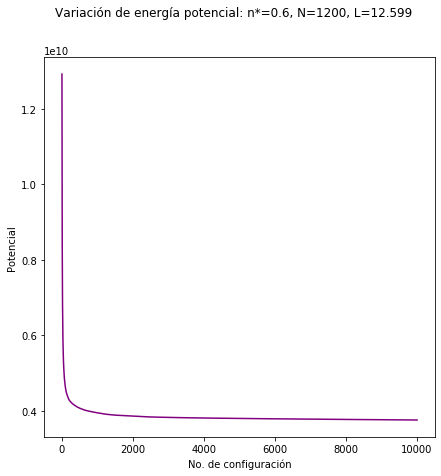

In [158]:
#Graficamos la variación de energía potencial total a través de la variación de configuraciones
fig = plt.figure()
fig.set_size_inches(7,7)
fig.suptitle('Variación de energía potencial: n*=0.6, N=1200, L=12.599')
ax4 = fig.add_subplot()
ax4.plot(np.linspace(0,nStep, nStep), vTraza, c = 'purple')
#ax4.set_ylim([1e8, 2e8])
ax4.set_xlabel('No. de configuración')
ax4.set_ylabel('Potencial')

**c) Función de distribución radial**

In [147]:
#Calculamos la distribución radial
rt, gdr = gdr1(Mx, My, Mz, radC, L, nStep, nr, N, ki)

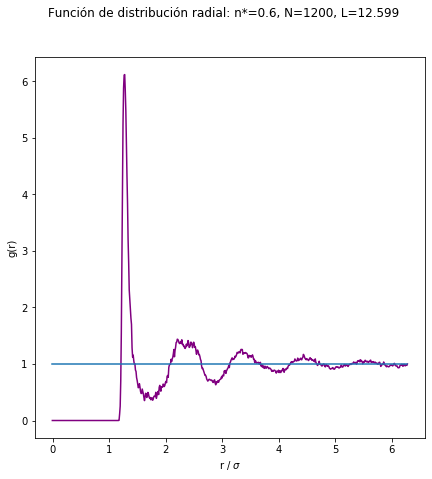

In [160]:
#Graficamos la función de distribución radial
fig, ax = plt.subplots(1,1)
fig.set_size_inches(7,7)
fig.suptitle('Función de distribución radial: n*=0.6, N=1200, L=12.599')
ax.plot(rt, gdr, c='purple')
ax.plot([rt.min(), rt.max()],[1,1])

ax.set_ylabel("g(r)")
ax.set_xlabel("r / $\sigma$")

plt.show()

**d) Valor promedio de la Energía Potencial del sistema**

In [155]:
#Calculamos el promedio de la energía potencial del sistema
v = vTraza[6000:]
VProm = v.mean()
print("El promedio de la energía potencial es ", VProm)

El promedio de la energía potencial es  3770027300.2979517


**e) Valor promedio de la Presión del sistema**

In [166]:
#Calculamos la presión del sistema
phs = pres(rt, gdr, nr)
print('La presión del sistema es: PHS =', phs)

ICONTACTO =  628 , GDR DE CONTACTO =  1.0003115854306746
La presión del sistema es: PHS = 1.8570286112359065
